#### Lake level extraction by using swot_l2_hr_pixc data (take dianchi as example)
具体步骤：（1）data reading ->（2）geophysical correction and elevation reference conversion   
->（3）outliers removing ->（4）Lake level calculation ->（5）time-series data processing




In [25]:
import os
import pickle 
import datetime
import numpy as np
import xarray as xr
from glob import glob
import geopandas as gpd
import contextily as ctx
from rasterio.plot import show
import matplotlib.pyplot as plt
from utils.swot_utils import IQR_filter
from utils.date_transform import date_to_decimal, decimal_to_date


In [26]:
### Lakes: chenghai, dianchi, erhai, fuxian, lugu, qilu, xingyun, yangzonghai, yilong
lake_name = 'yilong'
dir_pixc = 'data/swot_l2/pixc/'+ lake_name +'-lake'
path_lake_vec = 'data/lakes-vec/'+lake_name+'_s2_20240415.gpkg'


#### (1) swot pixc data reading and checking

In [27]:
## Check original _readout.nc raster file.
paths_file = [os.path.join(dir_pixc, file) for file in os.listdir(dir_pixc) if 'readout' in file and '.nc' in file]
paths_file = sorted(paths_file, key=lambda x: x.split('/')[-1].split('_')[-5])
print(len(paths_file))
id = 30
path_file = paths_file[id]
print(path_file)
## read one pixc data 
pixc_nc = xr.open_dataset(path_file)
pixc_nc


102
data/swot_l2/pixc/yilong-lake/SWOT_L2_HR_PIXC_008_396_113R_20231228T094938_20231228T094949_PGC0_01_readout.nc


<xarray.Dataset>
Dimensions:           (points: 127139)
Coordinates:
    latitude          (points) float64 ...
    longitude         (points) float64 ...
Dimensions without coordinates: points
Data variables:
    height            (points) float32 ...
    solid_earth_tide  (points) float32 ...
    pole_tide         (points) float32 ...
    load_tide_fes     (points) float32 ...
    iono_cor_gim_ka   (points) float32 ...
    geoid             (points) float32 ...
    pixel_area        (points) float32 ...
    geolocation_qual  (points) float64 ...
Attributes:
    description:                 cloud of geolocated interferogram pixels
    interferogram_size_azimuth:  3277
    interferogram_size_range:    4568
    looks_to_efflooks:           1.5506990083910441
    num_azimuth_looks:           7.0
    azimuth_offset:              4

In [28]:
## auxiliary data
lake_gpd = gpd.read_file(path_lake_vec).to_crs(4326)
lake_gpd


,DN,geometry
0,1,"POLYGON ((102.60917 23.66932, 102.60936 23.669..."


Text(0.5, 1.0, 'yilong')

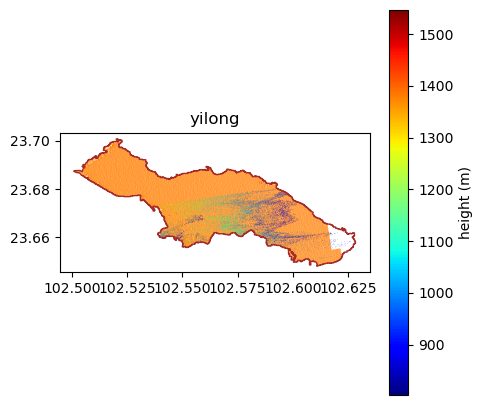

In [29]:
fig, ax = plt.subplots(figsize=(5,5))
scat = ax.scatter(x=pixc_nc.longitude, y=pixc_nc.latitude, c=pixc_nc.height,
            s=0.1, edgecolor='none', cmap='jet')
lake_gpd.plot(ax=ax, edgecolor='Brown', facecolor='none', linewidth=1)
# ctx.add_basemap(ax, crs=lake_gpd.crs.to_string())  ## time comsuming
fig.colorbar(scat).set_label('height (m)')
ax.set_title(lake_name)


#### （2）Select pixel cloud data of the given lake region.

In [ ]:
def height_cor(pixc_nc):
    """geophysical corrections for the height data.
       ! no inverse barometric correction.
    """
    height = pixc_nc.height.values
    solid_tide = pixc_nc.solid_earth_tide.values
    pole_tide = pixc_nc.pole_tide.values
    load_tide = pixc_nc.load_tide_fes.values
    iono_corr = pixc_nc.iono_cor_gim_ka.values  ## LakeSP product not have this correction.
    return height - (solid_tide + pole_tide + load_tide + iono_corr)    

heights_cor = height_cor(pixc_nc=pixc_nc)
heights_cor = heights_cor - pixc_nc.geoid.values   ## to egm2008 height


#### (3) Outlier removing using IQR method.

In [31]:
heights_cor_IQR, IQR = IQR_filter(heights_cor)
iter = 0
while IQR > 0.5:    
    iter += 1
    heights_cor_IQR_mask = heights_cor_IQR.mask
    heights_cor_IQR, IQR = IQR_filter(heights_cor_IQR.filled(np.nan))
    heights_cor_IQR.mask = heights_cor_IQR.mask | heights_cor_IQR_mask
    if iter == 3: break   ## max iteration: 4 times.
print(IQR)


0.465576171875


Text(0.5, 1.0, 'yilong')

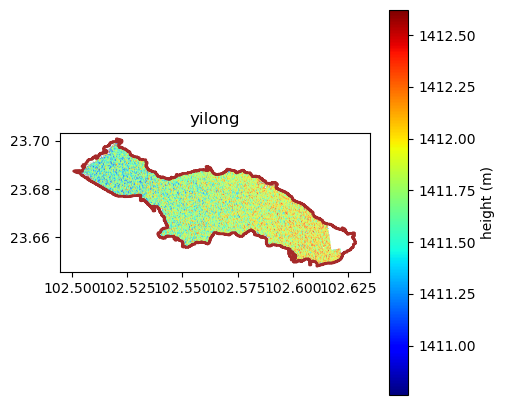

In [33]:
# rsimg_io = readTiff(path_img)
# crs='EPSG:4326'
fig, ax = plt.subplots(figsize=(5,5))
scat = ax.scatter(x=pixc_nc.longitude[~heights_cor_IQR.mask], y=pixc_nc.latitude[~heights_cor_IQR.mask], \
                  c=heights_cor[~heights_cor_IQR.mask], s=0.1, edgecolor='none', cmap='jet')
lake_gpd.plot(ax=ax, edgecolor='Brown', facecolor='none', linewidth=2)
fig.colorbar(scat).set_label('height (m)')
ax.set_title(lake_name)


#### (4) Lake level extraction (the mean and std values of the heights)  

In [34]:
### area weighting heights
def area_averaged(heights, areas):
  pixel_heights_sum = np.sum(areas*heights)
  pixel_AreaWeighted_height = pixel_heights_sum/np.sum(areas)
  weighted_var = [(heights[i] - pixel_AreaWeighted_height)**2*areas[i] for i in range(heights.shape[0])]
  weighted_var_sum = np.sum(weighted_var)
  weighted_std = np.sqrt(weighted_var_sum/sum(areas))
  return pixel_AreaWeighted_height, weighted_std

pixel_area = pixc_nc.pixel_area.values
pixel_height_ = heights_cor[~heights_cor_IQR.mask]
pixel_area_ = pixel_area[~heights_cor_IQR.mask]
pixel_AreaWeighted_height, weighted_dev = area_averaged(heights=pixel_height_, areas=pixel_area_)
print('Area Weighted height:', pixel_AreaWeighted_height)
print('Area Weighted deviation: ', weighted_dev)


Area Weighted height: 1411.7756
Area Weighted deviation:  0.2675556399286984


#### (5) time-series lake level retrieval by using the pixc data (merge the steps above into one).

In [35]:
## get acquisition time 
dates_data = [path.split('_')[-4] for path in paths_file]
dates_data = [date[0:4]+'-'+date[4:6]+'-'+date[6:8]+'T'+date[9:11]+':'+date[11:13]+':'+date[13:15]
              for date in dates_data]
## convert date to decimal
dates_decimal = [date_to_decimal(date) for date in dates_data]
dates_decimal = [round(date, 5) for date in dates_decimal]
dates_decimal[11]


2023.81867

mac pro: time comsuming (for erhai): 1 min 29 seconds    
mac mini: time comsuming (for erhai): 13 seconds   
mac air: time comsuming (for erhai): 29 seconds

In [36]:
heights_lake_mean, heights_lake_std = {}, {}
for i, path in enumerate(paths_file):
  print(i, path)
  date_decimal = dates_decimal[i]
  ## (1) data reading
  pixc_nc = xr.open_dataset(path)
  ## (2) geophysical corrections and convert to egm2008 height.
  heights_cor = height_cor(pixc_nc=pixc_nc)
  heights_cor =  heights_cor - pixc_nc.geoid.values  ## to egm2008 height  
  # pixc_nc = pixc_nc.assign(heights_cor=(["points"], heights_cor))
  ## (3) outliers removing using IQR method.
  iter = 0
  heights_cor_IQR, IQR = IQR_filter(heights_cor)
  while IQR > 0.6:    
      iter += 1
      heights_cor_IQR_mask = heights_cor_IQR.mask
      heights_cor_IQR, IQR = IQR_filter(heights_cor_IQR.filled(np.nan))
      heights_cor_IQR.mask = heights_cor_IQR.mask | heights_cor_IQR_mask
      if iter == 2: break   ## max iteration: 4 times.
  if IQR > 0.6: continue
  if (~heights_cor_IQR.mask).sum() < 100: continue  ## the threshold of the number of valid measurements. 
  ## (4) lake level calculation (area weighted average and std of the heights).
  # mask_da = xr.DataArray(heights_cor_IQR.mask, dims=["points"], coords={"points": pixc_nc.points})
  # pixc_nc_IQR = pixc_nc.where(~mask_da, drop=True)
  pixel_area = pixc_nc.pixel_area.values
  pixel_heights_ = heights_cor_IQR[~heights_cor_IQR.mask]
  pixel_area_ = pixel_area[~heights_cor_IQR.mask]
  pixel_AreaWeighted_height, weighted_std = area_averaged(heights=pixel_heights_, areas=pixel_area_)
  heights_lake_mean[date_decimal] = pixel_AreaWeighted_height
  heights_lake_std[date_decimal] = weighted_std


0 data/swot_l2/pixc/yilong-lake/SWOT_L2_HR_PIXC_553_023_196L_20230616T045819_20230616T045830_PGC0_01_readout.nc
1 data/swot_l2/pixc/yilong-lake/SWOT_L2_HR_PIXC_001_396_113R_20230804T083404_20230804T083415_PGC0_01_readout.nc
2 data/swot_l2/pixc/yilong-lake/SWOT_L2_HR_PIXC_002_396_113R_20230825T051908_20230825T051919_PGC0_01_readout.nc
3 data/swot_l2/pixc/yilong-lake/SWOT_L2_HR_PIXC_003_049_196L_20230902T164600_20230902T164611_PGC0_01_readout.nc
4 data/swot_l2/pixc/yilong-lake/SWOT_L2_HR_PIXC_003_049_196R_20230902T164600_20230902T164611_PGC0_01_readout.nc
5 data/swot_l2/pixc/yilong-lake/SWOT_L2_HR_PIXC_003_118_113L_20230905T034158_20230905T034209_PGC0_01_readout.nc
6 data/swot_l2/pixc/yilong-lake/SWOT_L2_HR_PIXC_003_396_113R_20230915T020415_20230915T020426_PGC0_01_readout.nc
7 data/swot_l2/pixc/yilong-lake/SWOT_L2_HR_PIXC_004_396_113R_20231005T224916_20231005T224927_PGC0_01_readout.nc
8 data/swot_l2/pixc/yilong-lake/SWOT_L2_HR_PIXC_005_049_196L_20231014T101607_20231014T101619_PGC0_01_rea

#### (6) time-series outliers removing

In [37]:
heights_lake_mean_filtered = heights_lake_mean.copy()
heights_lake_std_filtered = heights_lake_std.copy()
heights = list(heights_lake_mean.values())
dates = list(heights_lake_mean.keys())
for i, date in enumerate(dates):
    ### define the temporal window to one year.
    date_decimal_min, date_decimal_max = date-0.5, date+0.5
    id_win = np.where((np.array(dates) >= date_decimal_min) \
                      & (np.array(dates) < date_decimal_max))[0].tolist()
    id_win.remove(i)     ## delete the lake level of the current date.
    heights_win = [heights[j] for j in id_win]
    mean_height_year, std_height_year = np.mean(heights_win), np.std(heights_win)
    max_height_year = mean_height_year + 3*std_height_year
    min_height_year = mean_height_year - 3*std_height_year
    if heights[i] > max_height_year or heights[i] < min_height_year:
        heights_lake_mean_filtered.pop(date)
        heights_lake_std_filtered.pop(date)


Text(0.5, 1.0, 'Lake level (m) in yilong Lake')

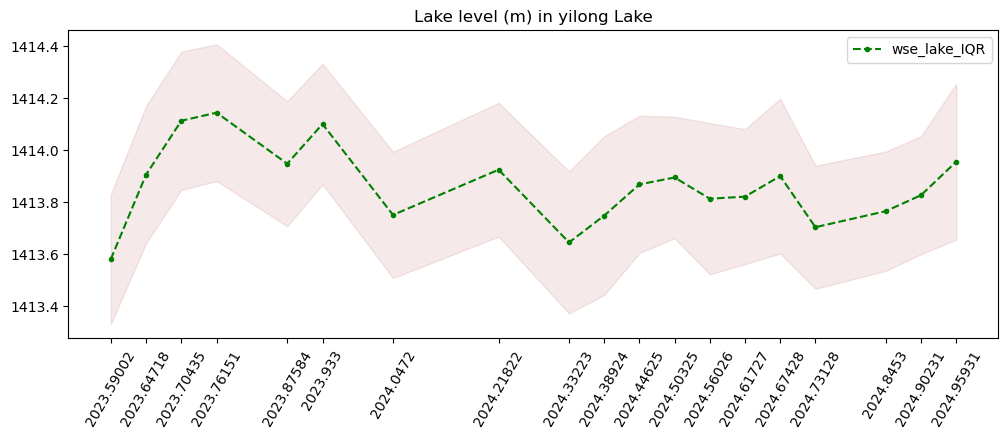

In [38]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(heights_lake_mean_filtered.keys(), heights_lake_mean_filtered.values(), '--.', color='green', label='wse_lake_IQR')
ax.fill_between(heights_lake_mean_filtered.keys(), np.array([*heights_lake_mean_filtered.values()]) - np.array([*heights_lake_std_filtered.values()]), \
                np.array([*heights_lake_mean_filtered.values()]) + np.array([*heights_lake_std_filtered.values()]), color='Brown', alpha=0.1)
# ax.set_ylim([1495.5, 1497.5])
# ax.set_ylim([1800, 2000])
ax.set_xticks(list(heights_lake_mean_filtered.keys()))
ax.set_xticklabels(heights_lake_mean_filtered.keys(), rotation=60)
ax.legend()
ax.set_title('Lake level (m) in ' + lake_name + ' Lake')


In [39]:
# ## write numpy data in 
# path_save = 'data/swot_l2/pixc/'+ lake_name +'-lake/'+lake_name+'_heights_lake.pkl'
# with open(path_save, 'wb') as f:
#         pickle.dump(heights_lake_mean_filtered, f)


In [40]:
# with open('data/swot_l2/pixc/erhai-lake/erhai_heights_lake.pkl', 'rb') as f:
#     heights_lake_mean_222 = pickle.load(f)
# heights_lake_mean_222
